References:

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3/about_data

https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data

OpenAI. (2025). ChatGPT (September 25 version) [Large language model]. https://chat.openai.com/

Data can be downloaded from:

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3/data_preview#:~:text=Export

https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/data_preview#:~:text=Export

Data can be connected through API




### Project Code

In [4]:
# Import necessary libraries
import pandas as pd
import requests
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from rapidfuzz import process
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, auc, average_precision_score, f1_score, 
                             precision_recall_curve)

import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [5]:
# Retrieve and merge data
VEHICLE_API = "https://data.cityofchicago.org/resource/68nd-jvt3.json"
PEOPLE_API = "https://data.cityofchicago.org/resource/u6pd-qa9d.json"
LIMIT = 10000000

def fetch_data(api_url, limit=LIMIT):
    response = requests.get(f"{api_url}?$limit={limit}")
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        raise Exception(f"API Error {response.status_code}: {response.text}")

def load_and_merge_data():
    vehicles_df = fetch_data(VEHICLE_API)
    people_df = fetch_data(PEOPLE_API)

    vehicles_df['crash_date'] = pd.to_datetime(vehicles_df['crash_date'], errors='coerce')
    people_df['crash_date'] = pd.to_datetime(people_df['crash_date'], errors='coerce')

    # Filter data from September 2024 forward
    start_date = pd.Timestamp('2024-09-01')
    vehicles_df = vehicles_df[vehicles_df['crash_date'] >= start_date]
    people_df = people_df[people_df['crash_date'] >= start_date]
    
    vehicles_df = vehicles_df[['crash_record_id', 'crash_date', 'vehicle_id', 'make', 'model', 'maneuver', 'vehicle_defect']]
    people_df = people_df[['person_id', 'person_type', 'crash_record_id', 'vehicle_id',
                           'crash_date', 'age', 'sex', 'injury_classification']]

    # Drop records with missing values and transform data
    vehicles_df.dropna(subset=['make', 'model', 'vehicle_id','maneuver', 'vehicle_defect'], inplace=True)
    people_df.dropna(subset=['age', 'sex','injury_classification'], inplace=True)
    people_df['sex'] = people_df['sex'].str.strip().str.upper()
    people_df = people_df[people_df['age'].apply(lambda x: str(x).isdigit())]
    people_df['age'] = people_df['age'].astype(int)

    # Merge datasets
    df = pd.merge(vehicles_df, people_df, on=['crash_record_id', 'crash_date', 'vehicle_id'], how='left')

    return df

In [6]:
# Create z-scores based on age bins and sex 
def add_demographic_zscores(df):
    df['age_bin'] = pd.cut(
        df['age'],
        bins=[0, 18, 25, 35, 45, 55, 65, 120],
        labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']
    )

    df['age_z_agebin_sex'] = df.groupby(['age_bin', 'sex'], observed=True)['age'].transform(
        lambda x: (x - x.mean()) / x.std(ddof=0)
    )
    return df

In [7]:
# Fuzzy matching
def fuzzy_standardize_column(df, column_name, min_freq=20, threshold=85):

    value_counts = df[column_name].value_counts()
    standards = list(value_counts[value_counts >= min_freq].index)

    mapping = {}
    for val in df[column_name].unique():
        if pd.isna(val):
            continue
        # match, score, _ = process.extractOne(val, standards, score_cutoff=threshold)
        match = process.extractOne(val, standards, score_cutoff=threshold)
        if match:
            mapping[val] = match[0] 
        else:
            mapping[val] = "OTHER"

    df[column_name + '_clean'] = df[column_name].map(mapping)
    return df, mapping

In [8]:
# Sets 0 or 1 to indicate whether injury was present
def binarize_injury(df):
    df['injury_binary'] = df['injury_classification'].apply(
        lambda x: 0 if pd.isna(x) or (isinstance(x, str) and x.strip().upper() == 'NO INDICATION OF INJURY') else 1
    )
    return df


In [9]:
# Function to load, merge, clean, and transform data
def clean_and_prepare_data():
    df = load_and_merge_data()
    df = add_demographic_zscores(df)
    df, make_mapping = fuzzy_standardize_column(df, 'make', min_freq=20)
    df, model_mapping = fuzzy_standardize_column(df, 'model', min_freq=20)
    df = binarize_injury(df)
    return df, make_mapping, model_mapping


In [10]:
# Runs function to clean and prepare data 
df_cleaned, make_map, model_map = clean_and_prepare_data()

In [11]:
# Takes sample of data, sets features and targets 

df_cleaned = df_cleaned.sample(frac=1.0, random_state=17).reset_index(drop=True)
##########################
# Select features and target
features = ['make_clean', 'model_clean', 'age_z_agebin_sex']
target = 'injury_binary'
#############
# Drops records with missing data
df_cleaned = df_cleaned.dropna(subset=features + [target]).reset_index(drop=True)

# One-hot encoding of categorical variables
X_cat = pd.get_dummies(df_cleaned[['make_clean', 'model_clean']], drop_first=True)
X_num = df_cleaned[['age_z_agebin_sex']]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_cleaned[target].astype(int)

In [12]:
# Split into training, test, and validation test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=17
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=17
)

In [13]:
# class balance in training data set
np.bincount(y_train)

array([103912,  12925])

In [14]:
# Oversampling due to class imbalance in training data for injury target
smote = SMOTE(random_state=17)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [15]:
# Scale data to normalize it into values between 0 and 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Sets ratio to balance injury classes 
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Sets some parameters to evaluate for model performance
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [ratio]
}

# XGBoost Classifier
xgb = XGBClassifier(eval_metric='logloss', random_state=17)

# Uses RandomizedSearch to find best parameters to use for classifcation model
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='average_precision',
    cv=3,
    verbose=1,
    random_state=17,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train_resampled)
best_model = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [17]:
# Function to evaluate model
def evaluate_model(model, X, y, set_name='Validation'):
    proba = model.predict_proba(X)[:, 1]
    preds = model.predict(X)
    print(f"{set_name} Set Results:")
    print(classification_report(y, preds, digits=4))
    print(f"{set_name} ROC AUC: {roc_auc_score(y, proba):.4f}")
    print(f"{set_name} PR AUC: {average_precision_score(y, proba):.4f}")
    return proba

In [18]:
# Evaluate model using validation and test data sets
val_proba = evaluate_model(best_model, X_val_scaled, y_val, 'Validation')
test_proba = evaluate_model(best_model, X_test_scaled, y_test, 'Test')

Validation Set Results:
              precision    recall  f1-score   support

           0     0.9503    0.0530    0.1005     25979
           1     0.1138    0.9777    0.2039      3231

    accuracy                         0.1553     29210
   macro avg     0.5321    0.5154    0.1522     29210
weighted avg     0.8578    0.1553    0.1119     29210

Validation ROC AUC: 0.5633
Validation PR AUC: 0.1482
Test Set Results:
              precision    recall  f1-score   support

           0     0.9523    0.0559    0.1056     32473
           1     0.1141    0.9775    0.2043      4039

    accuracy                         0.1578     36512
   macro avg     0.5332    0.5167    0.1550     36512
weighted avg     0.8595    0.1578    0.1165     36512

Test ROC AUC: 0.5740
Test PR AUC: 0.1495


In [19]:
# Classification threshold tuning based on F1 score
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]

In [20]:
# Best threshold achieved for F1 score
best_thresh

0.82701653

In [21]:
# Apply parameters that achieved best F1 score thresholds for model to test data set
test_preds_thresh = (test_proba >= best_thresh).astype(int)
print(classification_report(y_test, test_preds_thresh, digits=4))

              precision    recall  f1-score   support

           0     0.9153    0.3079    0.4607     32473
           1     0.1217    0.7710    0.2102      4039

    accuracy                         0.3591     36512
   macro avg     0.5185    0.5394    0.3355     36512
weighted avg     0.8275    0.3591    0.4330     36512



In [22]:
# Copy of test data to run post-processing rules on 
df_test = df_cleaned.loc[X_test.index].copy()
# df_test

In [23]:
# Probabilty of predictions
df_test['model_proba'] = test_proba
# Use prediction when it gets to best prediction threshold
df_test['model_pred_thresh'] = test_preds_thresh

# Rule for parked vehicles
rule_parked = df_test['maneuver'].str.upper() == 'PARKED'

# Rule for no vehicle defects
rule_no_damage = df_test['vehicle_defect'].str.upper().isin(['NONE', 'NO DAMAGE'])

# Combine rules to process
rules_to_filter = rule_parked | rule_no_damage

# Apply rule-based filtering
df_test['final_pred'] = df_test['model_pred_thresh']
df_test.loc[(df_test['model_pred_thresh'] == 1) & (rules_to_filter), 'final_pred'] = 0

print("Test Results After Rule-Based Post-Processing:")
print(classification_report(y_test, df_test['final_pred'], digits=4))
print("PR AUC (raw proba unchanged):", average_precision_score(y_test, df_test['model_proba']))


Test Results After Rule-Based Post-Processing:
              precision    recall  f1-score   support

           0     0.9010    0.6795    0.7747     32473
           1     0.1343    0.3996    0.2010      4039

    accuracy                         0.6486     36512
   macro avg     0.5176    0.5396    0.4879     36512
weighted avg     0.8162    0.6486    0.7113     36512

PR AUC (raw proba unchanged): 0.14952717312046726


In [24]:
# Plot horizontal bar chart of class imbalance in injuries reported
def plot_horizontal_stacked_bar(df):

    counts = df['injury_binary'].value_counts().sort_index()
    labels = ['No Injury', 'Injury']
    colors = ['#FFA500', '#D62728']  # Orange, Red
    total = counts.sum()
    percentages = counts / total * 100

    fig, ax = plt.subplots(figsize=(10, 2))

    start = 0
    for i, (label, pct, color) in enumerate(zip(labels, percentages, colors)):
        ax.barh(0, pct, left=start, color=color, edgecolor='white')
        ax.text(start + pct / 2, 0, f"{pct:.1f}%", ha='center', va='center',
                fontsize=12, color='white', fontweight='bold')
        start += pct

    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("Injury Distribution (as % of Total)", fontsize=14, fontweight='bold')
    ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()


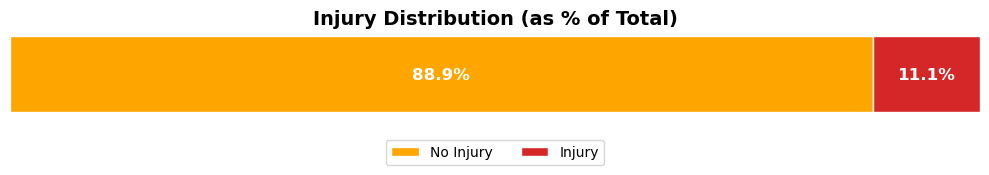

In [25]:
plot_horizontal_stacked_bar(df_cleaned)

In [26]:
# Creates and then plots results from confusion matrix taken before rule filtering and after reclassifying those records
def plot_prediction_comparison(df_test):

    pred_before = df_test['model_pred_thresh']
    pred_after = df_test['final_pred']
    true_labels = df_test['injury_binary']

    # Calculates confusion matrix results to use in plot
    def get_confusion_counts(preds, truths):
        TP = ((preds == 1) & (truths == 1)).sum()
        FP = ((preds == 1) & (truths == 0)).sum()
        TN = ((preds == 0) & (truths == 0)).sum()
        FN = ((preds == 0) & (truths == 1)).sum()
        return pd.Series({'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN})

    before_counts = get_confusion_counts(pred_before, true_labels)
    after_counts = get_confusion_counts(pred_after, true_labels)

    comp_df = pd.DataFrame({
        'Before Filtering': before_counts,
        'After Filtering': after_counts
    })

    # Plot results
    custom_colors = ['#D62728', '#FFA500']  # Red, Orange
    ax = comp_df.plot(
        kind='bar',
        figsize=(10, 7),
        color=custom_colors,
        edgecolor='black'
    )

    plt.title('Prediction Outcomes Before vs After Rule-Based Filtering', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0, fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(title='Prediction Stage', fontsize=11)
    ax.grid(False)
    ax.set_axisbelow(True)

    # Add count labels on bars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            ax.annotate(f'{int(height):,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10, weight='bold')

    # Calculate gain and drop between False Positives and True Negatives
    fp_before = before_counts['FP']
    fp_after = after_counts['FP']
    tn_before = before_counts['TN']
    tn_after = after_counts['TN']

    fp_drop = fp_before - fp_after
    tn_gain = tn_after - tn_before

    if fp_drop > 0 and tn_gain > 0:
        x_fp = 1  # FP bar index
        x_tn = 2  # TN bar index

        # Arrow placement
        y_fp = max(fp_before, fp_after)
        y_tn = max(tn_before, tn_after)
        arrow_y = max(y_fp, y_tn) - 400

        # Arrow from False Positives to True Negatives
        ax.annotate(
            '', xy=(x_tn, arrow_y), xytext=(x_fp, arrow_y),
            arrowprops=dict(arrowstyle="->", color='gray', linewidth=2)
        )

        # Annotation above the arrow
        ax.text((x_fp + x_tn) / 2, arrow_y + 8,
                f"{fp_drop} False Positives\nreclassified as True Negatives",
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='gray')

    plt.tight_layout()
    plt.show()

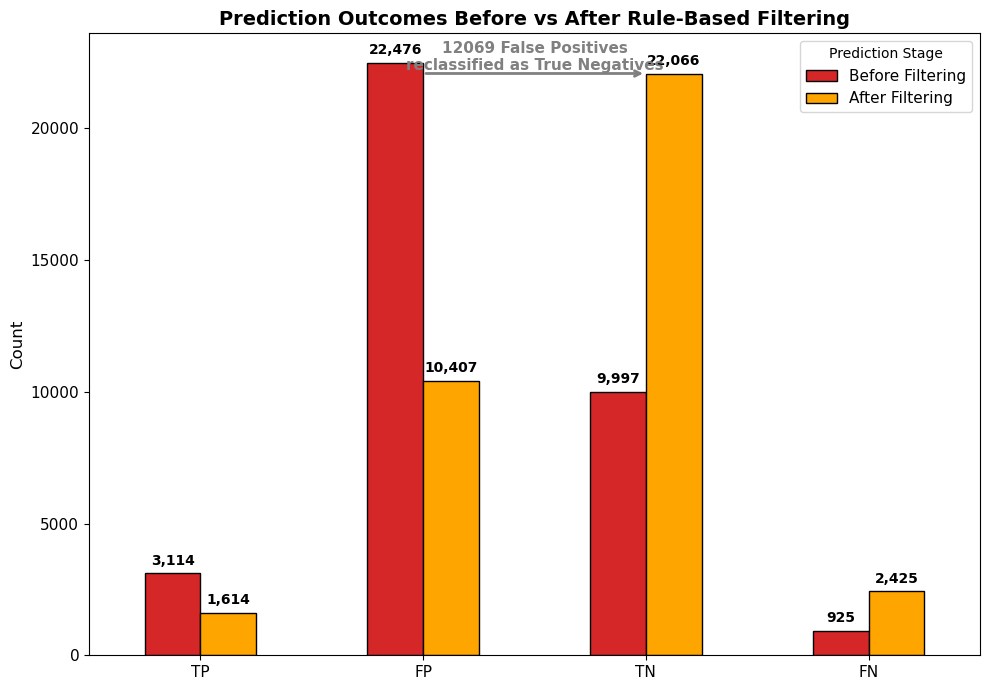

In [27]:
plot_prediction_comparison(df_test)

In [28]:
# Plot effectiveness of post processing filters (reassignments of injury predicted data to correct classification as non-injury data)
def plot_rule_filter_analysis(df_test):
    
    # Calculate results to use in pie chart
    filtered_out = df_test[(df_test['model_pred_thresh'] == 1) & (df_test['final_pred'] == 0)]
    filtered_true_negative = (filtered_out['injury_binary'] == 0).sum()
    filtered_false_negative = (filtered_out['injury_binary'] == 1).sum()

    # Displays for pie chart
    counts = [filtered_true_negative, filtered_false_negative]
    labels = [f"Corrected False Positives (TN)\n{filtered_true_negative:,}", f"Incorrectly Flipped (FN)\n{filtered_false_negative:,}"]
    colors = ['#FFA500', '#D62728']  # Orange (correct), Red (incorrect)

    # Plot pie
    plt.figure(figsize=(7, 6))
    wedges, texts, autotexts = plt.pie(
        counts,
        labels=labels,
        colors=colors,
        startangle=140,
        autopct='%1.1f%%',
        textprops={'fontsize': 11},
        wedgeprops=dict(edgecolor='white')
    )

    # Set font to white bold for inside thpe ie chart
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.title("Effectiveness of Rule-Based Filtering", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


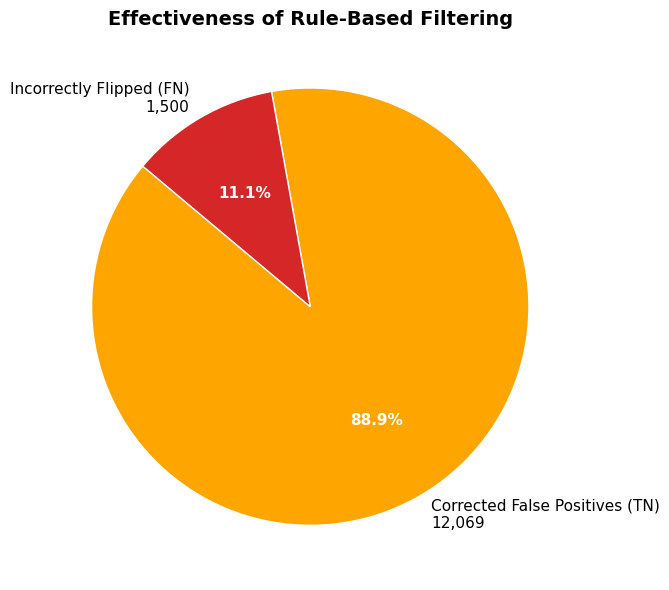

In [29]:
plot_rule_filter_analysis(df_test)

In [30]:
# Filter out specific reported models -- not reviewing motorcycles or other vehicles (just typical passenger vehicles)
excluded_models = ['OTHER', 'MOTORIZED', 'HARLEY-DAVIDSON', 'OTHER (EXPLAIN IN NARRATIVE)']
df_filtered = df_cleaned[~df_cleaned['model_clean'].str.upper().isin(excluded_models)]

# Group by make and model to calculate injury rate and total crashes
grouped = df_filtered.groupby(['make_clean', 'model_clean'])
stats = grouped['injury_binary'].agg(['mean', 'count']).reset_index()
stats.columns = ['make_clean', 'model_clean', 'injury_rate', 'crash_count']

# Filter to only show make and models with at least 100 crash records
filtered_stats = stats[stats['crash_count'] >= 100]
top_risky = filtered_stats.sort_values(by='injury_rate', ascending=False).head(10)

print(top_risky)

    make_clean model_clean  injury_rate  crash_count
349       JEEP      LAREDO     0.209524          105
613    PONTIAC          G6     0.196581          117
304   INFINITI        FX35     0.191489          141
114  CHEVROLET      COBALT     0.183544          158
762      VOLVO         S60     0.181818          132
156      DODGE     CALIBER     0.178218          101
307   INFINITI         G37     0.172093          215
18        AUDI          A5     0.171429          105
621    PONTIAC        VIBE     0.170940          117
231       FORD      TAURUS     0.169811          424


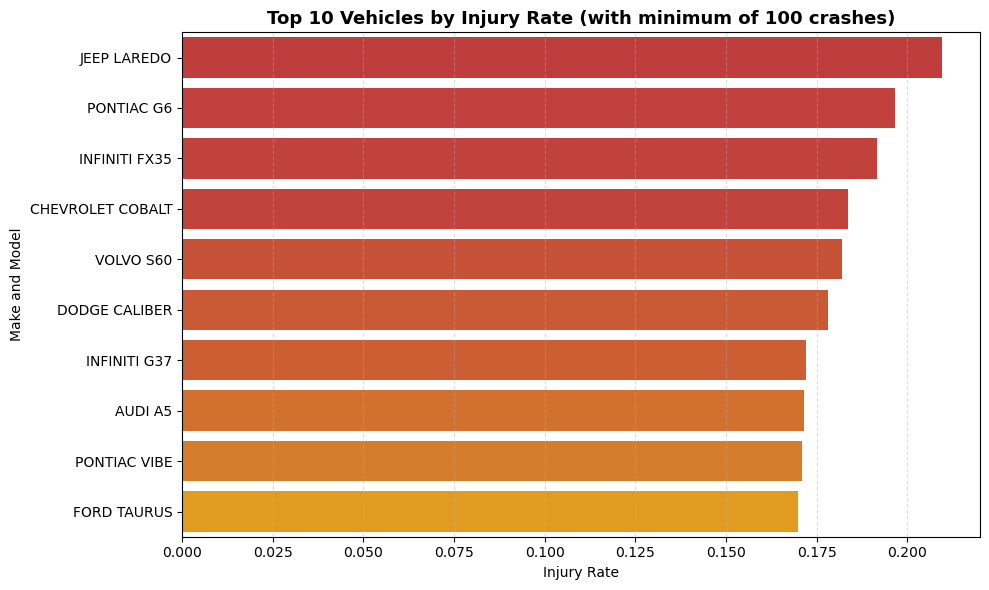

In [31]:
# Normalizes injury_rate for gradient color scheme to be used on bars
norm = plt.Normalize(top_risky['injury_rate'].min(), top_risky['injury_rate'].max())

# Custom red-to-orange colormap
cmap = mcolors.LinearSegmentedColormap.from_list("RedOrange", ['#D62728', '#FFA500']) 

# Assigns each injury_rate to a color
colors = [cmap(norm(val)) for val in top_risky['injury_rate']]

# Plots results
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_risky,
    y=top_risky['make_clean'] + ' ' + top_risky['model_clean'],
    x='injury_rate',
    palette=colors,
    hue='injury_rate',
    legend=False
)
plt.xlabel('Injury Rate')
plt.ylabel('Make and Model')
plt.title('Top 10 Vehicles by Injury Rate (with minimum of 100 crashes)', fontsize=13, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [32]:
# Filter for age bin '0-18'
age_0_18 = df_filtered[df_filtered['age_bin'] == '0-18']

# Group and calculate injury stats
grouped_0_18 = age_0_18.groupby(['make_clean', 'model_clean'])['injury_binary'].agg(['mean', 'count']).reset_index()
grouped_0_18.columns = ['make_clean', 'model_clean', 'injury_rate', 'crash_count']

# Keep only make/models with at least 100 crashes
filtered_0_18 = grouped_0_18[grouped_0_18['crash_count'] >= 100]

# Get top 10 risky vehicles for 0-18
top_0_18 = filtered_0_18.sort_values(by='injury_rate', ascending=False).head(10)


In [33]:
# Filter for all other age bins
age_other = df_filtered[df_filtered['age_bin'] != '0-18']

# Group and calculate injury stats
grouped_other = age_other.groupby(['make_clean', 'model_clean'])['injury_binary'].agg(['mean', 'count']).reset_index()
grouped_other.columns = ['make_clean', 'model_clean', 'injury_rate', 'crash_count']

# Filter to only make and models with at least 100 crashes
filtered_other = grouped_other[grouped_other['crash_count'] >= 100]

# Get top 10 risky vehicles for other ages
top_other = filtered_other.sort_values(by='injury_rate', ascending=False).head(10)


In [34]:
# Assign labels to age groups to plot and combine make and model
top_other['age_group'] = '19+'
top_0_18['age_group'] = '0-18'
top_0_18['make_model_full'] = top_0_18['make_clean'] + ' ' + top_0_18['model_clean']
top_other['make_model_full'] = top_other['make_clean'] + ' ' + top_other['model_clean']

# Combine data from both age groups 
combined = pd.concat([top_0_18, top_other])

In [35]:
# Sort vaues by injury rate descending and then get top 5 riskiest vehicles
combined = combined.sort_values(by='injury_rate', ascending=False)
combined  = combined.head(5)

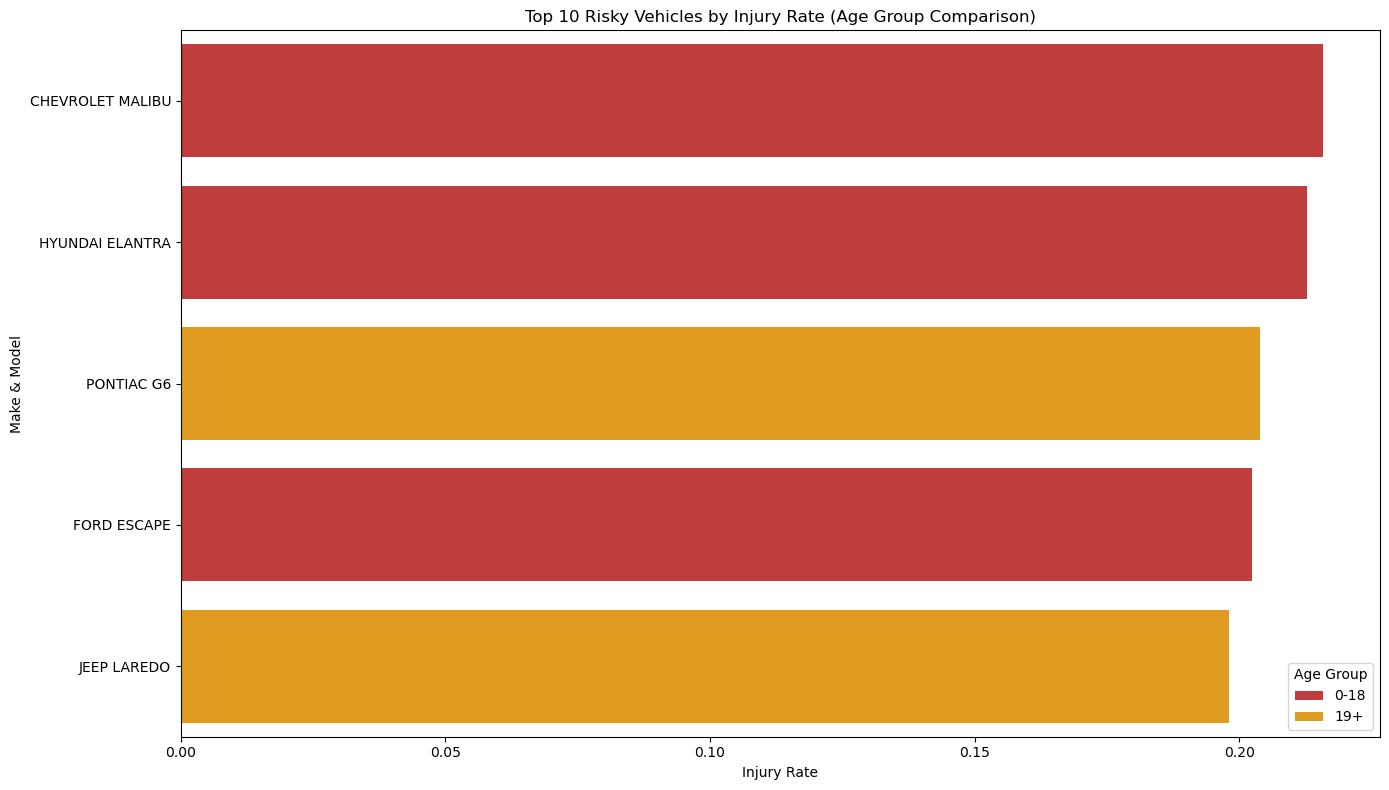

In [36]:
# plots top 5 riskiest vehicles when looking at age group 0-18 and all others
plt.figure(figsize=(14, 8))
sns.barplot(
    data=combined,
    x='injury_rate',
    y='make_model_full',
    hue='age_group',
    palette={'0-18': '#D62728', '19+': '#FFA500'}  # Red, Orange
)

plt.title('Top 10 Risky Vehicles by Injury Rate (Age Group Comparison)')
plt.xlabel('Injury Rate')
plt.ylabel('Make & Model')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()
